In [1]:
import pandas
import datetime
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
%pylab inline

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/scipy/cluster/vq.py:88: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _vq
/usr/local/lib/python2.7/dist-packages/scipy/cluster/hierarchy.py:178: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _hierarchy
/usr/local/lib/python2.7/dist-packages/sklearn/utils/__init__.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32


In [2]:
predFname = "../data/all_data.pred.test"
nBins=1
binTimeRes=60

In [3]:
def pred_bin_out(row, nBins):
    """
    Given the prediction label, get the actual
    output in bins by converting the label into
    binary representation. For ex, label 2 would
    convert to 10 and 5 to 101 and so on.
    """
    # Note we need the binary format to be consistent
    # with the actual labels, i.e., it depends on the 
    # number of bins. For example, 2 could be 10 or 010.
    binFormtStr = '{0:0' + str(nBins) + 'b}'
    predBinStr = binFormtStr.format(row["pred_label"])
    # Now add these into different pred bins
    for _n, _pb in enumerate(predBinStr):
        row["pbin_" + str(_n)] = int(_pb)
    if row["label"] == 0:
        if row["pred_label"] == 0:
            predType = "TN"
        else:
            predType = "FP"
    if row["label"] == 1:
        if row["pred_label"] == 1:
            predType = "TP"
        else:
            predType = "FN"
    row["pred_type"] = predType
    return row

In [4]:
# we need to carefully setup the column names
colNames = ["date"]
for _nb in range(nBins):
    colNames += [ "bin_" + str(_nb) ]
colNames += [ "label", "pred_label" ]
for _nb in range(nBins):
    # there are 2 probs for each bin
    # one zero prob and other 1 prob
    colNames += [ "prob_type_0_b_" + str(_nb) ]
    colNames += [ "prob_type_1_b_" + str(_nb) ]
predDF = pandas.read_csv(predFname, names=colNames,\
             header=0, parse_dates=["date"])
# get the columns showing the bin predictions
filterCols = [ col for col in predDF\
             if col.startswith('bin') ]
predDF = predDF.apply( pred_bin_out, args=(nBins,),\
                      axis=1 )
predDF.head()

,date,bin_0,label,pred_label,prob_type_0_b_0,prob_type_1_b_0,pbin_0,pred_type
0,1997-01-01 00:25:00,0,0,0,0.796452,0.203548,0,TN
1,1997-01-01 00:30:00,0,0,0,0.796452,0.203548,0,TN
2,1997-01-01 00:35:00,0,0,0,0.796452,0.203548,0,TN
3,1997-01-01 01:20:00,1,1,0,0.796452,0.203548,0,FN
4,1997-01-01 01:25:00,1,1,0,0.796452,0.203548,0,FN


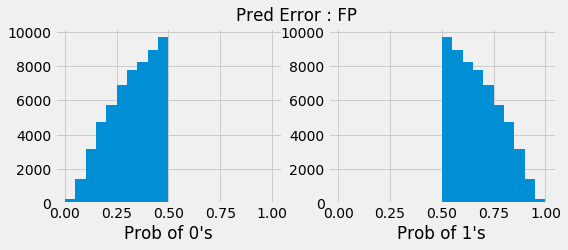

In [5]:
curr_pred_type = "FP"
plt.style.use("fivethirtyeight")
fig, axes = plt.subplots(nrows=1, ncols=2,\
                    figsize=(8,3), sharex=True)
pltDF = predDF[ predDF["pred_type"] == curr_pred_type]
axes[0].hist( pltDF["prob_type_0_b_0"].values )
axes[0].set_xlabel("Prob of 0's")
axes[1].hist( pltDF["prob_type_1_b_0"].values )
axes[1].set_xlabel("Prob of 1's")
fig.suptitle("Pred Error : " + curr_pred_type)

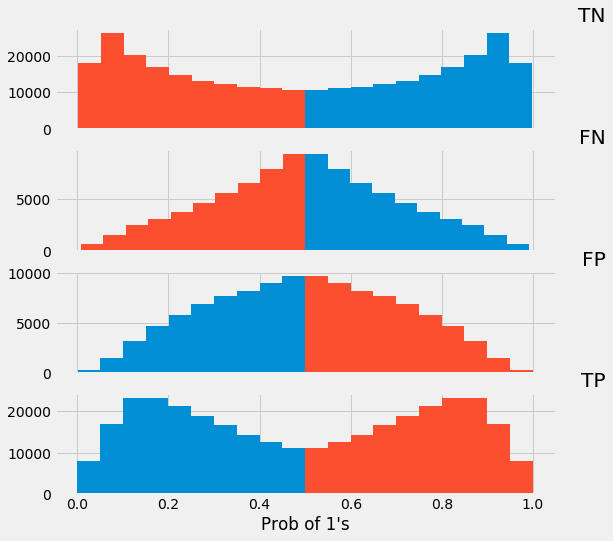

In [8]:
uniqPredTypes = predDF["pred_type"].unique()
fig, axes = plt.subplots(nrows=uniqPredTypes.shape[0], ncols=1,\
                    figsize=(8,8), sharex=True)
for _n, _cpt in enumerate(uniqPredTypes):
    pltDF = predDF[ predDF["pred_type"] == _cpt]
    axes[_n].hist( pltDF["prob_type_0_b_0"].values )
    axes[_n].hist( pltDF["prob_type_1_b_0"].values )
    axes[_n].set_title(_cpt, loc="right", x=1.1)
    if _n == len(uniqPredTypes) - 1:
        axes[_n].set_xlabel("Prob of 0's")
        axes[_n].set_xlabel("Prob of 1's")
fig.savefig("../plots/pred_prob_dist.png")